In [1]:
import cv2
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from utils import *
import os
from scipy import signal
from scipy.sparse import linalg
from scipy.sparse import csr_matrix
from scipy.sparse import lil_matrix
from scipy.sparse import save_npz
from numpy import *

## Application Function Definitions

In [23]:
#PLACE FUNCTIONS BELOW###

def saveBackWallImg(im_src,xs,ys,img_file_name):
    obj_img=np.copy(im_src[ys[0]:ys[2],xs[0]:xs[2]])
    obj_img=cv2.resize(obj_img, (256,256), interpolation = cv2.INTER_AREA)
    cv2.imwrite(img_file_name.split('.')[0]+'/backwall.jpeg',obj_img)
    return

"""
    Takes an array of three integers and returns the value determined by
        third value - first value /(third value - second value)
        
    helper function to determine height of 3D box
"""
def getBoxHeight(ys):
    return (ys[2]-ys[0])/float(ys[2]-ys[1])

"""
    https://stackoverflow.com/questions/3252194/numpy-and-line-intersections
"""
def perp(a) :
    b = np.empty_like(a)
    b[0] = -a[1]
    b[1] = a[0]
    return b

"""
    line segment a given by endpoints a1, a2
    line segment b given by endpoints b1, b2
    return 
"""
def seg_intersect(a1,a2, b1,b2):
    da = a2-a1
    db = b2-b1
    dp = a1-b1
    dap = perp(da)
    denom = np.dot( dap, db)
    num = np.dot( dap, dp )
    return (num / denom.astype(float))*db + b1

def computeHomography(pts1, pts2,normalization_func=None):
    '''
    Compute homography that maps from pts1 to pts2 using SVD
     
    Input: pts1 and pts2 are 3xN matrices for N points in homogeneous
    coordinates. 
    
    Output: H is a 3x3 matrix, such that pts2~=H*pts1
    '''
    numOfRows=2*len(pts1)
    numOfCols=9
    A=np.zeros((numOfRows,numOfCols))
    
    for i in range(0,len(pts1)):
        (aX,aY) = pts1[i,:]
        (bX,bY) = pts2[i,:]
        
        A[2*i] = np.array([-aX,-aY,-1,0,0,0,bX*aX,bX*aY,bX])
        A[2*i+1] = np.array([0,0,0,-aX,-aY,-1,bY*aX,bY*aY,bY])
    
    U,s,v = np.linalg.svd(A)
    
    H = np.eye(3)
    
    H = np.reshape(v[-1], (3,3))
    H = np.divide(H,H[2,2])
    return H

"""
    Below diagram outlines the 8 points of the room that will be calculated in order to 
        3D room

####################################################
####################################################
##### P0 ################################# P1 ######
####################################################
####################################################
################## P2 ############# P3 #############
####################################################
####################################################
####################################################
####################################################
####################################################
################## P4 ############# P5 #############
####################################################
####################################################
##### P6 ################################# P7 ######
####################################################
####################################################

"""
def getBoundingBox3DCoords(xs,ys,pxl_to_d_ratio,box_height,focal):
    P0=((xs[0]-xs[1])*pxl_to_d_ratio,box_height,0)
    P1=((xs[2]-xs[1])*pxl_to_d_ratio,box_height,0)
    P2=((xs[0]-xs[1])*pxl_to_d_ratio,box_height,-focal/float(ys[2]-ys[1]))
    P3=((xs[2]-xs[1])*pxl_to_d_ratio,box_height,-focal/float(ys[2]-ys[1]))
    P4=((xs[0]-xs[1])*pxl_to_d_ratio,0,-focal/float(ys[2]-ys[1]))
    P5=((xs[2]-xs[1])*pxl_to_d_ratio,0,-focal/float(ys[2]-ys[1]))
    P6=((xs[0]-xs[1])*pxl_to_d_ratio,0,0)
    P7=((xs[2]-xs[1])*pxl_to_d_ratio,0,0)
    return [P0,P1,P2,P3,P4,P5,P6,P7]

def getHomographyOfRightWall(img,xs,ys):
    w=img.shape[1]
    h=img.shape[0]
    
    #two points that determine P3 --> P1 line
    P0 = np.array([xs[1],abs(h-ys[1])])
    P1 = np.array([xs[2],abs(h-ys[0])])

    #two points that determine P7 --> P1 line
    P2 = np.array([w,0])
    P3 = np.array([w,h])
    
    #pixel coordinate of P3, P5
    P00=np.array([ys[0],xs[2]])
    P10=np.array([ys[2],xs[2]])
    
    intersectionP=seg_intersect(P0,P1,P2,P3)
    intersectionP[1]=h-intersectionP[1]
    #pixel coordinate of P1
    P01=np.array([intersectionP[1],intersectionP[0]])
    
    #two points that determine P5 --> P7 line
    P0 = np.array([xs[1],abs(h-ys[1])])
    P1 = np.array([xs[2],abs(h-ys[2])])

    intersectionP=seg_intersect(P0,P1,P2,P3)
    intersectionP[1]=h-intersectionP[1]
    #pixel coordinate of P7
    P11=np.array([intersectionP[1],intersectionP[0]])
    
    uvCoords=np.array([[0.,0.],[256.,0.],[0.,256.],[256.,256.]])
    picCoords=np.array([[P00[1],P00[0]],[P01[1],P01[0]],[P10[1],P10[0]],[P11[1],P11[0]]])
    H,status=cv2.findHomography(picCoords,uvCoords)
    return H

def getHomographyOfLeftWall(img,xs,ys):
    w=img.shape[1]
    h=img.shape[0]
    
    #two points that determine P2 --> P0 line
    P0 = np.array([xs[1],abs(h-ys[1])])
    P1 = np.array([xs[0],abs(h-ys[0])])

    #two points that determine P6 --> P0 line
    P2 = np.array([0,0])
    P3 = np.array([0,h])
    
    #pixel coordinate of P2, P4
    P01=np.array([ys[0],xs[0]])
    P11=np.array([ys[2],xs[0]])
    
    intersectionP=seg_intersect(P0,P1,P2,P3)
    intersectionP[1]=h-intersectionP[1]
    #pixel coordinate of P1
    P00=np.array([intersectionP[1],intersectionP[0]])
    
    #two points that determine P4 --> P6 line
    P0 = np.array([xs[1],abs(h-ys[1])])
    P1 = np.array([xs[0],abs(h-ys[2])])

    intersectionP=seg_intersect(P0,P1,P2,P3)
    intersectionP[1]=h-intersectionP[1]
    #pixel coordinate of P6
    P10=np.array([intersectionP[1],intersectionP[0]])
    
    uvCoords=np.array([[0.,0.],[256.,0.],[0.,256.],[256.,256.]])
    picCoords=np.array([[P00[1],P00[0]],[P01[1],P01[0]],[P10[1],P10[0]],[P11[1],P11[0]]])
    H,status=cv2.findHomography(picCoords,uvCoords)
    return H

def getHomographyOfBottomWall(img,xs,ys):
    w=img.shape[1]
    h=img.shape[0]
    
    #two points that determine P5 --> P7 line
    P0 = np.array([xs[1],abs(h-ys[1])])
    P1 = np.array([xs[2],abs(h-ys[2])])

    #two points that determine P6 --> P7 line
    P2 = np.array([0,0])
    P3 = np.array([w,0])
    
    #pixel coordinate of P2, P4
    P00=np.array([ys[2],xs[0]])
    P01=np.array([ys[2],xs[2]])
    
    intersectionP=seg_intersect(P0,P1,P2,P3)
    intersectionP[1]=h-intersectionP[1]
    #pixel coordinate of P1
    P11=np.array([intersectionP[1],intersectionP[0]])
    
    #two points that determine P4 --> P6 line
    P0 = np.array([xs[1],abs(h-ys[1])])
    P1 = np.array([xs[0],abs(h-ys[2])])

    intersectionP=seg_intersect(P0,P1,P2,P3)
    intersectionP[1]=h-intersectionP[1]
    #pixel coordinate of P6
    P10=np.array([intersectionP[1],intersectionP[0]])
    
    uvCoords=np.array([[0.,0.],[256.,0.],[0.,256.],[256.,256.]])
    picCoords=np.array([[P00[1],P00[0]],[P01[1],P01[0]],[P10[1],P10[0]],[P11[1],P11[0]]])
    H,status=cv2.findHomography(picCoords,uvCoords)
    return H

def getHomographyOfTopWall(img,xs,ys):
    w=img.shape[1]
    h=img.shape[0]
    
    #two points that determine P2 --> P0 line
    P0 = np.array([xs[1],abs(h-ys[1])])
    P1 = np.array([xs[0],abs(h-ys[0])])

    #two points that determine P0 --> P1 line
    P2 = np.array([0,h])
    P3 = np.array([w,h])
    
    #pixel coordinate of P2, P3
    P10=np.array([ys[0],xs[0]])
    P11=np.array([ys[0],xs[2]])
    
    intersectionP=seg_intersect(P0,P1,P2,P3)
    intersectionP[1]=h-intersectionP[1]
    #pixel coordinate of P1
    P00=np.array([intersectionP[1],intersectionP[0]])
    
    #two points that determine P3 --> P1 line
    P0 = np.array([xs[1],abs(h-ys[1])])
    P1 = np.array([xs[2],abs(h-ys[0])])

    intersectionP=seg_intersect(P0,P1,P2,P3)
    intersectionP[1]=h-intersectionP[1]
    #pixel coordinate of P1
    P01=np.array([intersectionP[1],intersectionP[0]])
    
    
    uvCoords=np.array([[0.,0.],[256.,0.],[0.,256.],[256.,256.]])
    picCoords=np.array([[P00[1],P00[0]],[P01[1],P01[0]],[P10[1],P10[0]],[P11[1],P11[0]]])
    H,status=cv2.findHomography(picCoords,uvCoords)
    return H
    
    

"""
P0 --> bottom left
P1 --> bottom right
P2 --> top left
P3 --> top right

nV --> normal vector
"""
def saveObjPlane(P0,P1,P2,P3,planeName,img_file_name):
    nV=["0.000000","0.000000","0.000000"]
    if(planeName=="backwall"):
        nV[2]="1.000000"
    elif(planeName=="rightwall"):
        nV[0]="-1.000000"
    elif(planeName=="leftwall"):
        nV[0]="1.000000"
    elif(planeName=="bottomwall"):
        nV[1]="1.000000"
    elif(planeName=="topwall"):
        nV[1]="-1.000000"
    else:
        nV[2]="1.000000"
    
    vertexStrings=[' '.join(["mtllib",planeName+".mtl\no Plane"]),
                   ' '.join(["v",str(P0[0]),str(P0[1]),str(P0[2])]),
                   ' '.join(["v",str(P1[0]),str(P1[1]),str(P1[2])]),
                   ' '.join(["v",str(P2[0]),str(P2[1]),str(P2[2])]),
                   ' '.join(["v",str(P3[0]),str(P3[1]),str(P3[2])]),
                   ' '.join(["vt","0.000000","0.000000"]),
                   ' '.join(["vt","1.000000","0.000000"]),
                   ' '.join(["vt","0.000000","1.000000"]),
                   ' '.join(["vt","1.000000","1.000000"]),
                   ' '.join(["vn",nV[0],nV[1],nV[2]]),
                   ' '.join(["usemtl",planeName+"Material"]),
                   ' '.join(["s","off"]),
                   ' '.join(["f","1/1/1","2/2/1","4/4/1","3/3/1"]),
                  ]
    vertexStrings='\n'.join(vertexStrings)
    mltStrings=[' '.join(["newmtl",planeName+"Material"]),
                   ' '.join(["map_Kd",planeName+".jpeg"]),
                   ' '.join(["map_Ka",planeName+".jpeg"]),
                  ]
    mtlStrings='\n'.join(mltStrings)
    file = open(img_file_name.split('.')[0]+'/'+planeName+'.obj', 'w')
    file.write(vertexStrings)
    file.close()
    file = open(img_file_name.split('.')[0]+'/'+planeName+'.mtl', 'w')
    file.write(mtlStrings)
    file.close()
    
"""
    Input:
    
    mask_coords is a set of three coordinates representing the top left
        vanishing point in the back wall, and the bottom right of the back wall
    img_file_name is of type of string, representing the name of the image file to load and turn into 3D room
    f is the (estimated - if true value is unknown) focal length of the image 
    
    Function Definition
    blendIntoPicture takes a single image with a certain set of satisfied properties, and turns it 
        into a 3D image room as explained in the paper TIP - Tour Into the Picture - by Horry et al.
        
    Function Output:
        Outputs texture maps and obj files in a folder named the same as the name of the image
        
"""
def blendIntoPicture(mask_coords,img_file_name,f):
    xs = mask_coords[0]
    ys = mask_coords[1]
    xs = [int(i) for i in xs]
    ys = [int(i) for i in ys]

    im_src = cv2.imread(img_file_name)
    saveBackWallImg(im_src,xs,ys,img_file_name)


    #constants
    focal=f
    camera_height=1
    camera_pos=(0,1,0)

    box_height=getBoxHeight(ys)
    pxl_to_d_ratio=float(box_height)/(ys[2]-ys[0])


    coords3D=getBoundingBox3DCoords(xs,ys,pxl_to_d_ratio,box_height,focal)
    saveObjPlane(coords3D[4],coords3D[5],coords3D[2],coords3D[3],'backwall',img_file_name)
    saveObjPlane(coords3D[6],coords3D[4],coords3D[0],coords3D[2],'leftwall',img_file_name)
    saveObjPlane(coords3D[5],coords3D[7],coords3D[3],coords3D[1],'rightwall',img_file_name)
    saveObjPlane(coords3D[6],coords3D[7],coords3D[4],coords3D[5],'bottomwall',img_file_name)
    saveObjPlane(coords3D[2],coords3D[3],coords3D[0],coords3D[1],'topwall',img_file_name)



    im_src = cv2.imread(img_file_name)
    H=getHomographyOfRightWall(im_src,xs,ys)
    im_dst = cv2.cvtColor(cv2.warpPerspective(im_src,H, (256,256)),cv2.COLOR_BGR2RGB)
    cv2.imwrite(img_file_name.split('.')[0]+'/rightwall.jpeg',cv2.cvtColor(im_dst,cv2.COLOR_RGB2BGR))
    plt.figure()
    plt.imshow(im_dst)

    H=getHomographyOfLeftWall(im_src,xs,ys)
    im_dst = cv2.cvtColor(cv2.warpPerspective(im_src,H, (256,256)),cv2.COLOR_BGR2RGB)
    cv2.imwrite(img_file_name.split('.')[0]+'/leftwall.jpeg',cv2.cvtColor(im_dst,cv2.COLOR_RGB2BGR))
    plt.figure()
    plt.imshow(im_dst)

    H=getHomographyOfBottomWall(im_src,xs,ys)
    im_dst = cv2.cvtColor(cv2.warpPerspective(im_src,H, (256,256)),cv2.COLOR_BGR2RGB)
    cv2.imwrite(img_file_name.split('.')[0]+'/bottomwall.jpeg',cv2.cvtColor(im_dst,cv2.COLOR_RGB2BGR))
    plt.figure()
    plt.imshow(im_dst)

    H=getHomographyOfTopWall(im_src,xs,ys)
    im_dst = cv2.cvtColor(cv2.warpPerspective(im_src,H, (256,256)),cv2.COLOR_BGR2RGB)
    cv2.imwrite(img_file_name.split('.')[0]+'/topwall.jpeg',cv2.cvtColor(im_dst,cv2.COLOR_RGB2BGR))
    plt.figure()
    plt.imshow(im_dst)
    return coords3D
    
"""
    Input:
    mask_coords: 3 sets of Image coordinates of top left, vanishing point, and bottom left used to determine 3D room
    mask_fg_coords: 2 sets of Image coordinates top right, and bottom right image coordinates to determine FG image plane
    mask_fg_ground_coords: 2 sets of Image coordinates to determine where on the ground the FG image will be placed in the room
    img_file_name: string value of image file
    coords3D: 8 sets of 3D coordinate points that determine the 3D box
    focal: focal length at which the image was taken at.

"""
def foregroundObj(mask_coords,mask_fg_coords,mask_fg_ground_coords,img_file_name,coords3D,focal):
    xs = mask_fg_coords[0]
    ys = mask_fg_coords[1]
    xs = [int(i) for i in xs]
    ys = [int(i) for i in ys]

    xs_box = mask_coords[0]
    ys_box = mask_coords[1]
    xs_box = [int(i) for i in xs_box]
    ys_box = [int(i) for i in ys_box]
    
    xs_fg_ground = mask_fg_ground_coords[0]
    ys_fg_ground = mask_fg_ground_coords[1]
    xs_fg_ground = [int(i) for i in xs_fg_ground]
    ys_fg_ground = [int(i) for i in ys_fg_ground]
    
    picCoords=np.array([[0.,0.],[256.,0.],[0.,256.],[256.,256.]])
    worldCoords=np.array([[coords3D[4][0],coords3D[4][2]],[coords3D[5][0],coords3D[5][2]],[coords3D[6][0],coords3D[6][2]],[coords3D[7][0],coords3D[7][2]]])
    unProjectionMatrix=cv2.findHomography(picCoords,worldCoords)

    threeDCoordDepthLeft=unProjectionMatrix[0].dot(np.array([xs_fg_ground[0],ys_fg_ground[0],1.]))
    threeDCoordDepthRight=unProjectionMatrix[0].dot(np.array([xs_fg_ground[1],ys_fg_ground[1],1.]))

    box_height=getBoxHeight(ys_box)
    pxl_to_d_ratio=float(box_height)/(ys_box[2]-ys_box[0])

    #getting depth
    fg_depth=threeDCoordDepthLeft[1]

    hi=(ys[1]-ys[0])*pxl_to_d_ratio

    #getting bottom right
    bottomRight=np.array([threeDCoordDepthRight[0],0,threeDCoordDepthRight[1]])
    #getting bottom left
    bottonLeft=np.array([threeDCoordDepthLeft[0],0,threeDCoordDepthLeft[1]])
    #getting top right
    topRight=np.array([threeDCoordDepthRight[0],hi,threeDCoordDepthRight[1]])
    #getting top left
    topLeft=np.array([threeDCoordDepthLeft[0],hi,threeDCoordDepthLeft[1]])

    saveObjPlane(bottonLeft,bottomRight,topLeft,topRight,'fgobj',img_file_name)
    im_src = cv2.imread(img_file_name)
    savePlaneImg(im_src,xs,ys,'fgobj',img_file_name)
    hi=(ys[1]-ys[0])*pxl_to_d_ratio
    
    j=((ys_box[2]-ys_box[1])/(ys[1]-ys_box[1]))*((ys[0]-ys_box[1])/(ys[1]-ys_box[1]))    
    di=j*focal/(ys[0]-ys[1])

"""
    Helper function to save down foreground image plane
"""
def savePlaneImg(im_src,xs,ys,planeName,img_file_name):
    obj_img=np.copy(im_src[ys[0]:ys[1],xs[0]:xs[1]])
    obj_img=cv2.resize(obj_img, (256,256), interpolation = cv2.INTER_AREA)
    cv2.imwrite(img_file_name.split('.')[0]+'/'+planeName+'.jpeg',obj_img)
    return

## Preparation

<IPython.core.display.Javascript object>


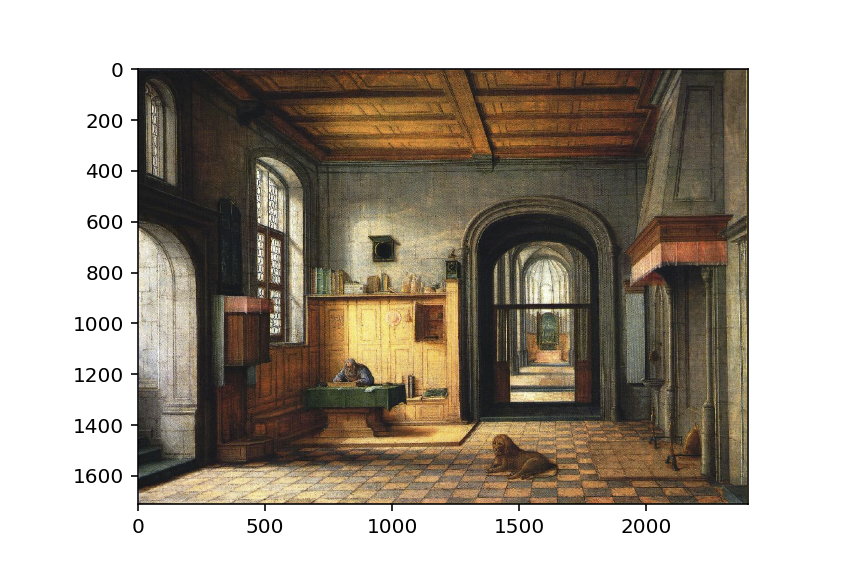

In [12]:
# Feel free to change image
img_file_name='painting.JPG'
background_img = cv2.cvtColor(cv2.imread(img_file_name), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.figure()
plt.imshow(background_img)

if not os.path.exists(img_file_name.split('.')[0]):
    os.makedirs(img_file_name.split('.')[0])

If it doesn't get you to the drawing mode, then rerun this function again.


<IPython.core.display.Javascript object>


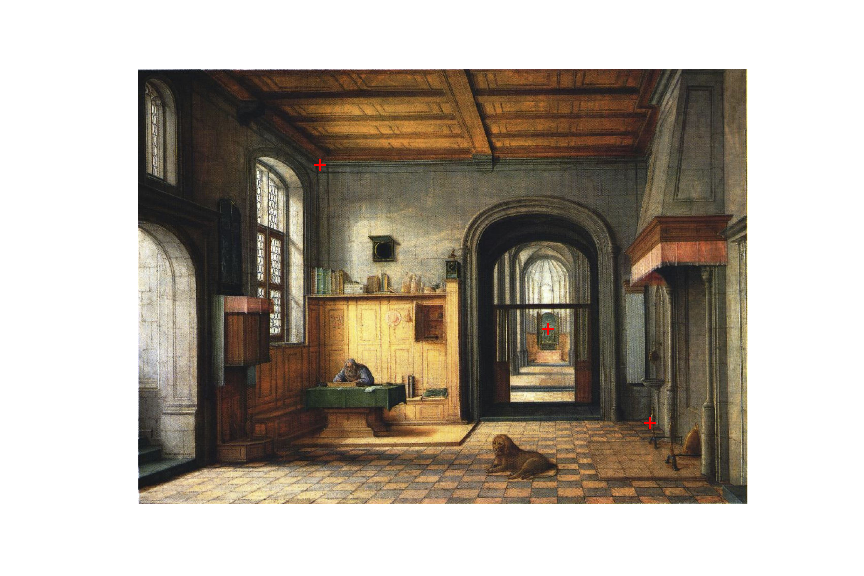

In [5]:
# Feel free to change image
object_img = cv2.cvtColor(cv2.imread(img_file_name), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
import matplotlib.pyplot as plt
%matplotlib notebook
mask_coords = specify_mask(object_img)

<IPython.core.display.Javascript object>


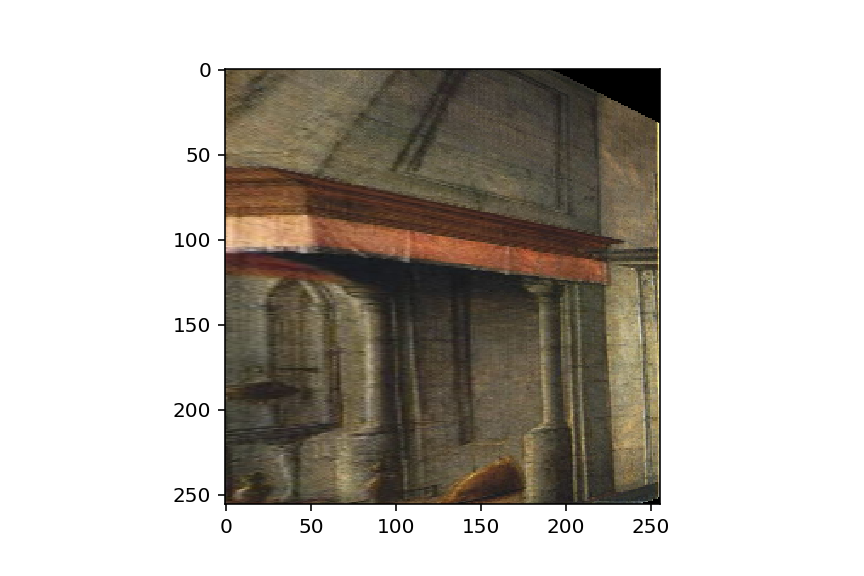

<IPython.core.display.Javascript object>


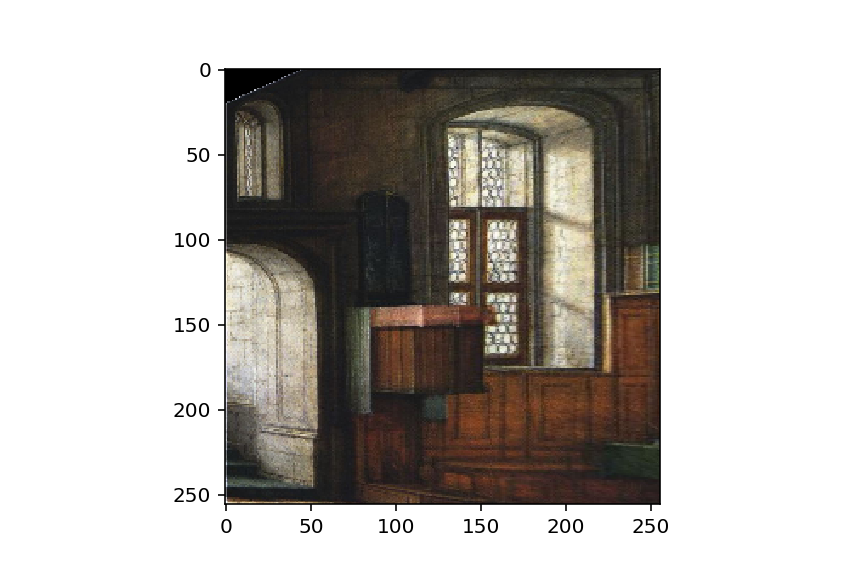

<IPython.core.display.Javascript object>


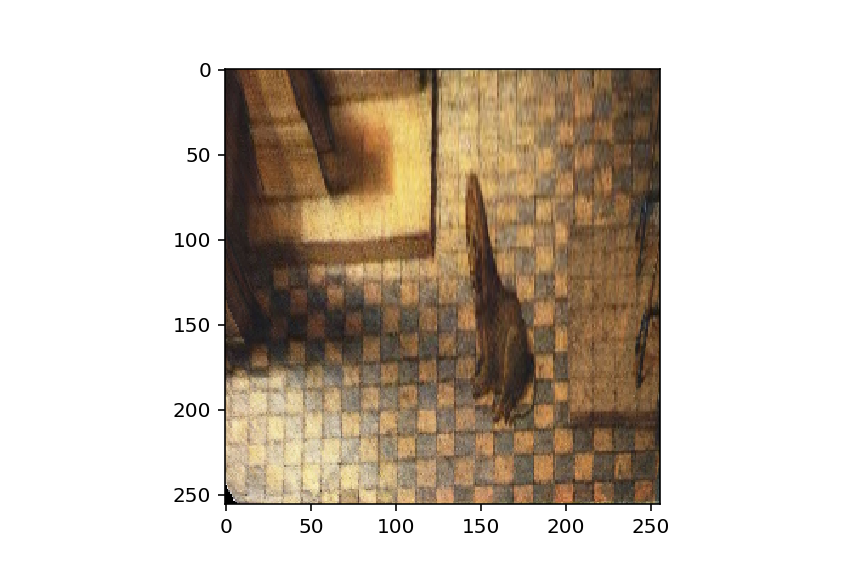

<IPython.core.display.Javascript object>


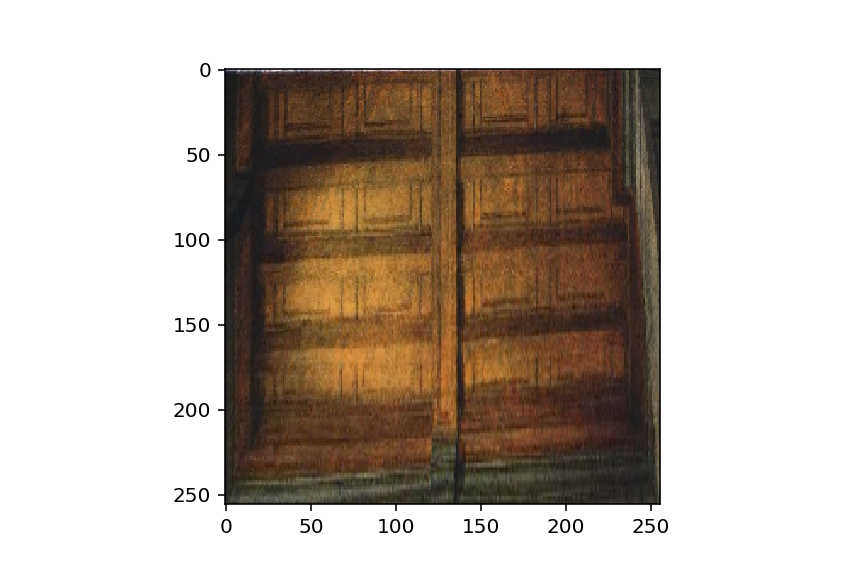

In [21]:
#the last value is the focal length
focal=1000
coords3D=blendIntoPicture(mask_coords,img_file_name,focal)

## Foreground Image Preparation

In [58]:
#######################################################################################################
## for this part, you can choose a foreground object that is on conveniently placed on the bottom floor ##
#######################################################################################################

If it doesn't get you to the drawing mode, then rerun this function again.


<IPython.core.display.Javascript object>


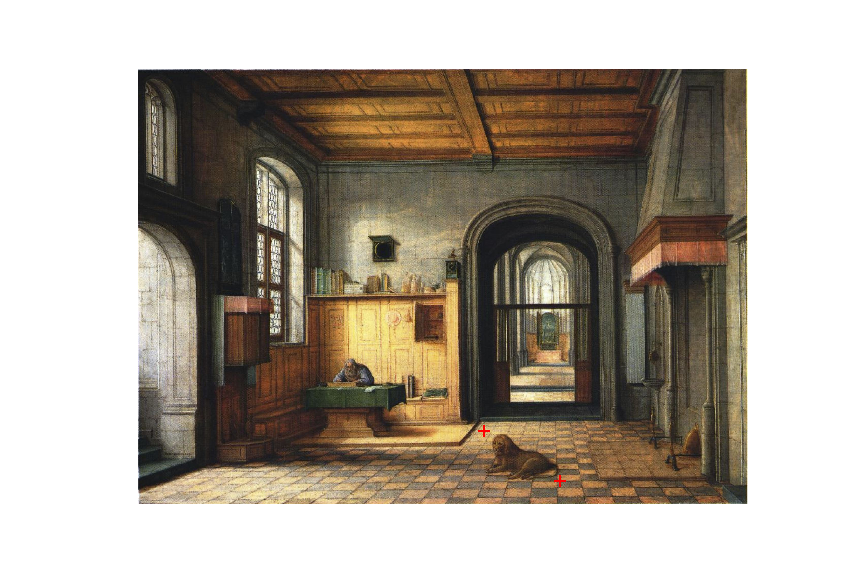

In [14]:
# Feel free to change image
object_img = cv2.cvtColor(cv2.imread(img_file_name), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
import matplotlib.pyplot as plt
%matplotlib notebook
mask_fg_coords = specify_mask(object_img)

If it doesn't get you to the drawing mode, then rerun this function again.


<IPython.core.display.Javascript object>


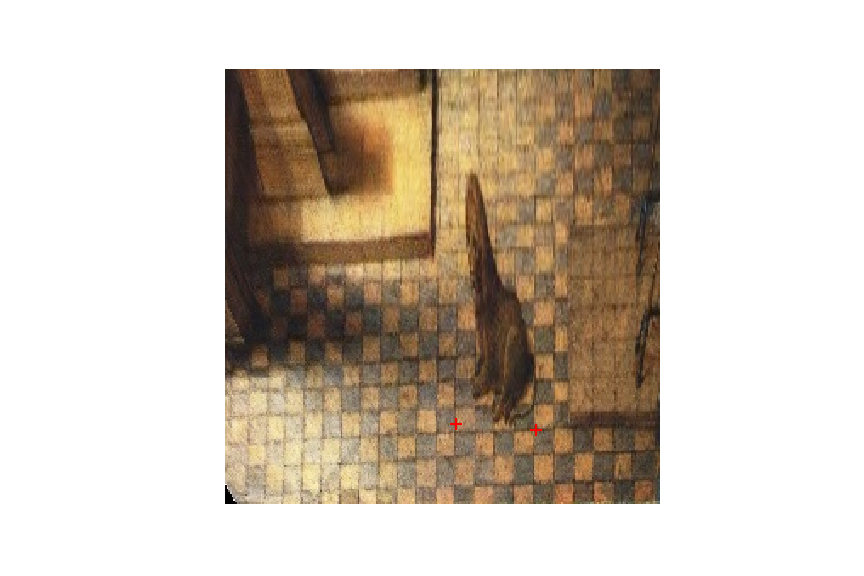

In [15]:
#select ground points
object_img = cv2.cvtColor(cv2.imread(img_file_name.split('.')[0]+'/bottomwall.jpeg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
import matplotlib.pyplot as plt
%matplotlib notebook
mask_fg_ground_coords = specify_mask(object_img)

In [24]:
foregroundObj(mask_coords,mask_fg_coords,mask_fg_ground_coords,img_file_name,coords3D,focal)

In [ ]:
########################################################################################################################

In [ ]:
########################################################################################################################

In [ ]:
########################################################################################################################

## Second Example

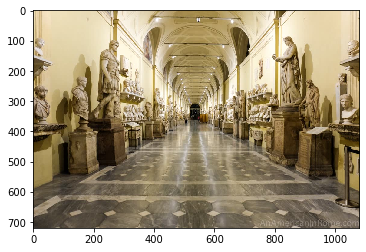

In [2]:
#2nd image
# Feel free to change image
img_file_name='museum.jpg'
background_img = cv2.cvtColor(cv2.imread(img_file_name), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.figure()
plt.imshow(background_img)

If it doesn't get you to the drawing mode, then rerun this function again.


<IPython.core.display.Javascript object>


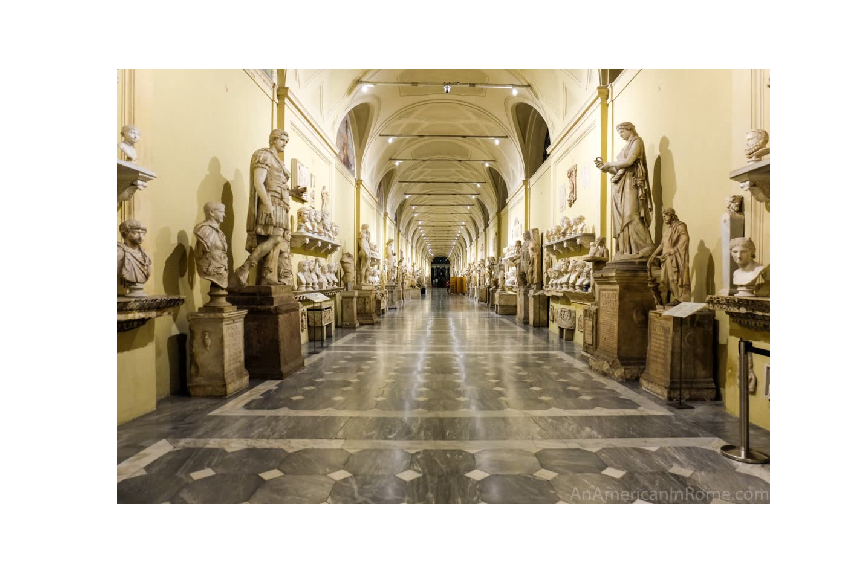

In [4]:
# Feel free to change image
object_img = cv2.cvtColor(cv2.imread(img_file_name), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
import matplotlib.pyplot as plt
%matplotlib notebook
mask_coords = specify_mask(object_img)

<IPython.core.display.Javascript object>


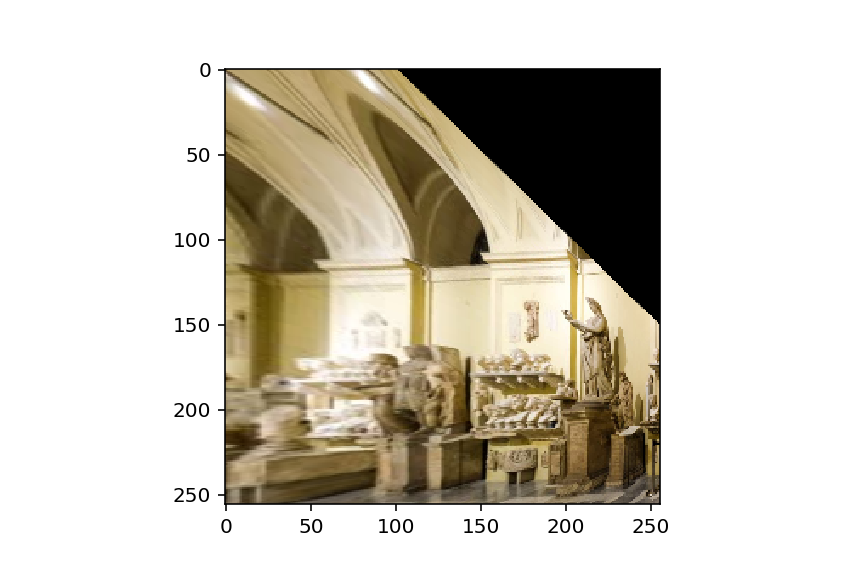

<IPython.core.display.Javascript object>


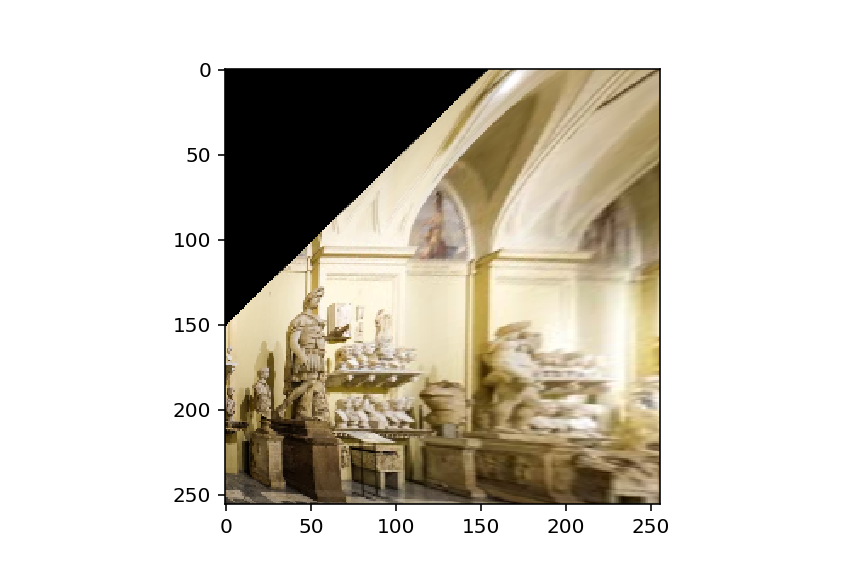

<IPython.core.display.Javascript object>


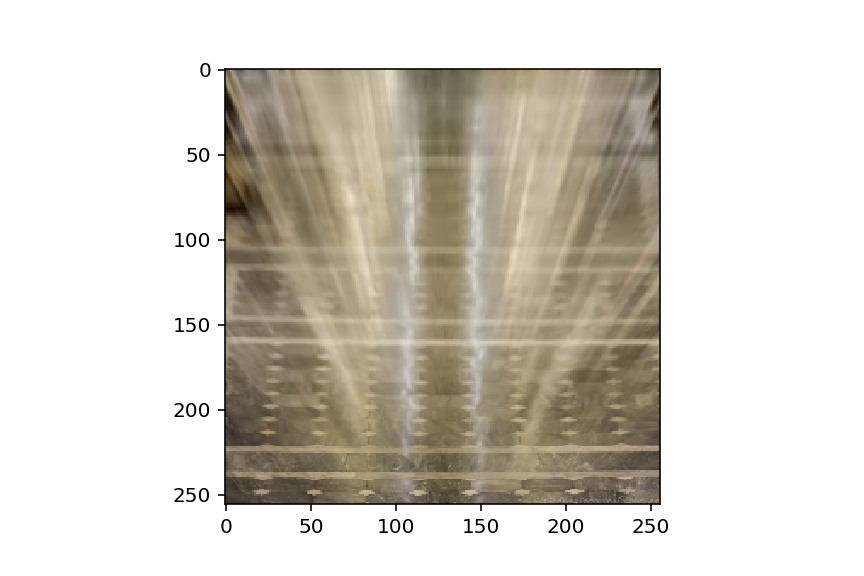

<IPython.core.display.Javascript object>


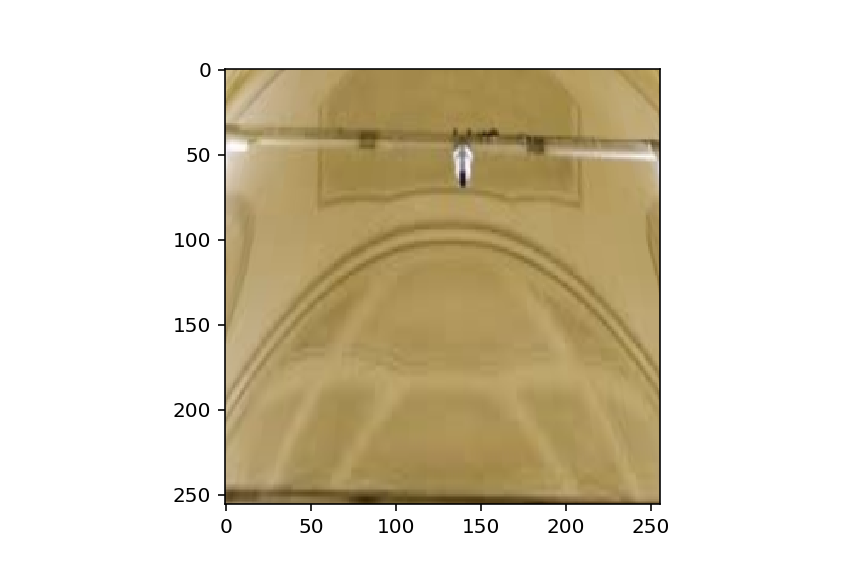

[(-1.4126984126984126, 4.571428571428571, 0),
 (1.4285714285714284, 4.571428571428571, 0),
 (-1.4126984126984126, 4.571428571428571, -4.761904761904762),
 (1.4285714285714284, 4.571428571428571, -4.761904761904762),
 (-1.4126984126984126, 0, -4.761904761904762),
 (1.4285714285714284, 0, -4.761904761904762),
 (-1.4126984126984126, 0, 0),
 (1.4285714285714284, 0, 0)]

In [33]:
#the last value is the focal length
blendIntoPicture(mask_coords,img_file_name,300)